In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline

In [2]:
# local variable for path to the dump files: you might want to change this

DUMP_PATH= 'T:/Desktop/UvA/Jaar3/OndragelijkRepo/noclone/WoogleDumps/'

In [3]:
dossier_dtypes = {'dc_identifier': str, 'dc_title': str, 'dc_description': str, 'dc_type': str,
                 'foi_type_description': str, 'dc_publisher_name': str, 'dc_publisher': str,
                 'dc_source': str, 'foi_valuation': str, 'foi_requestText': str,
       'foi_decisionText': str, 'foi_isAdjourned': str, 'foi_requester': str}

document_dtypes = {'dc_identifier': str, 'foi_dossierId': str, 'dc_title': str, 'foi_fileName': str,
       'dc_format': str, 'dc_source': str, 'dc_type': str, 'foi_nrPages': int}

In [4]:
dossier_dataframe = pd.read_csv(DUMP_PATH+ 'woo_dossiers.csv.gz', parse_dates=['foi_publishedDate', 'dc_date_year', 'foi_requestDate',
                                                                                'foi_decisionDate', 'foi_retrievedDate'], dtype=dossier_dtypes).set_index('dc_identifier')

document_dataframe = pd.read_csv(DUMP_PATH+ 'woo_documents.csv.gz').set_index('dc_identifier')

# zelfde index met mooie linkjes
dossier_dataframe.index='https://doi.wooverheid.nl/?doi='+dossier_dataframe.index
document_dataframe.foi_dossierId='https://doi.wooverheid.nl/?doi='+document_dataframe.foi_dossierId

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\431477450.py:4: DtypeWarning: Columns (9,10,11,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  document_dataframe = pd.read_csv(DUMP_PATH+ 'woo_documents.csv.gz').set_index('dc_identifier')


In [5]:
# aantal pagina's per dossier berekenen

pages = document_dataframe.groupby('foi_dossierId')['foi_nrPages'].sum()

In [6]:
excel = pd.read_csv('data/laatste_meting/Woo-verzoeken _ Nakijken - Nakijken.csv', index_col=0)
excel.index.name = 'foi_dossierId'
excel.shape

(1762, 11)

In [10]:
nakijken = pd.read_csv('data/nakijken - nakijken.csv', index_col=0)
nakijken.index.name = 'foi_dossierId'
nakijken['foi_decisionDate'] = nakijken.apply(lambda x: pd.to_datetime(x['foi_decisionDate'], errors='coerce'), axis=1)
nakijken['verzoek_datum'] = nakijken.apply(lambda x: pd.to_datetime(x['verzoek_datum'], errors='coerce'), axis=1)
nakijken['looptijd_foi'] = None
nakijken['looptijd_foi'] = nakijken.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)
nakijken = nakijken[nakijken['looptijd_foi'].notnull()]

nakijken.index='https://doi.wooverheid.nl/?doi='+nakijken.index

nacomb = nakijken.join(dossier_dataframe, how='left', rsuffix='_dossier')

nacomb = nacomb.join(pages, how='left')

nacomb.shape

(1388, 30)

In [11]:
# join met behoud van de index van het excel bestand 'nakijken'

combined = excel.join(dossier_dataframe, how='left', rsuffix='_dossier')

combined = combined.join(pages, how='left')

combined.shape

(1762, 33)

In [12]:
def remove_outliers_foi(df):
    limits = df[df['looptijd_foi'] >= 0].groupby('dc_publisher_name')['looptijd_foi'].quantile(0.995)
    loose_frames = []
    for ministerie in df['dc_publisher_name'].unique(): 
        min_filter = df[df['dc_publisher_name'] == ministerie]['looptijd_foi'] <= limits[ministerie]
        loose_frames.append(min_filter)

    cutoff_filter = pd.concat(loose_frames)
    df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
    return df

def verschil_foi(row):
    dagtekening = row['foi_decisionDate']
    verzoek = row['verzoek_datum']
    if isinstance(dagtekening, datetime) and isinstance(verzoek, datetime):
        return dagtekening - verzoek
    else:
        return None
    
def td_to_days(td):
    if td != None:
        return td.days
    
def shorten_pubname(x):
    if x == 'Ministerie Van Algemene Zaken':
        return 'AZ'
    elif x == 'Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties':
        return 'BZK'
    elif x == 'Ministerie Van Defensie':
        return 'DEF'
    elif x == 'Ministerie Van Buitenlandse Zaken':
        return 'BuZa'
    elif x == 'Ministerie Van Financiën':
        return 'FIN'
    elif x == 'Ministerie Van Sociale Zaken En Werkgelegenheid':
        return 'SZW'
    elif x == 'Ministerie Van Economische Zaken En Klimaat':
        return 'EZK'
    elif x == 'Ministerie Van Landbouw, Natuur En Voedselkwaliteit':
        return 'LNV'
    elif x == 'Ministerie Van Onderwijs, Cultuur En Wetenschap':
        return 'OCW'
    elif x == 'Ministerie Van Infrastructuur En Waterstaat':
        return 'I&W'
    elif x == 'Ministerie Van Justitie En Veiligheid':
        return 'J&V'
    elif x == 'Ministerie Van Volksgezondheid, Welzijn En Sport':
        return 'VWS'
    else:
        print('ho daar gaat iets goed mis')

combined['dc_publisher_name_short'] = combined['dc_publisher_name'].apply(lambda x: shorten_pubname(x))

In [13]:
# het zijn nog geen datetime objecten

combined.shape, combined['verzoek_datum'].apply(lambda x: type(x)).value_counts()

((1762, 34),
 verzoek_datum
 <class 'str'>      1758
 <class 'float'>       4
 Name: count, dtype: int64)

In [14]:
# sommige rijen van de kolom verzoek_datum had een '?' ipv een datum
# het is 'geforceerd' overgezet naar een datetime object, alles wat niet omgezet kan worden wordt een 'NaT' (missende datum)

print(f"Dagtekening isna: {combined['foi_decisionDate'].isna().sum()}, Verzoek datum isna: {combined['verzoek_datum'].isna().sum()}")

combined['foi_decisionDate'] = combined.apply(lambda x: pd.to_datetime(x['foi_decisionDate'], errors='coerce'), axis=1)
combined['verzoek_datum'] = combined.apply(lambda x: pd.to_datetime(x['verzoek_datum'], errors='coerce'), axis=1)

print(f"Dagtekening isna: {combined['foi_decisionDate'].isna().sum()}, Verzoek datum isna: {combined['verzoek_datum'].isna().sum()}")

# looptijd opnieuw uitrekenen, in de kolom met looptijden (die 'deelbesluit' heet) zat ook andere data over deelbesluiten
combined['looptijd_foi'] = None
combined['looptijd_foi'] = combined.apply(lambda x: td_to_days(verschil_foi(x)), axis=1)

Dagtekening isna: 0, Verzoek datum isna: 4
Dagtekening isna: 0, Verzoek datum isna: 21


In [15]:
describe_zonder_outliers = remove_outliers_foi(combined).groupby('dc_publisher_name')['looptijd_foi'].describe().round(2)
describe_met_outliers = combined.groupby('dc_publisher_name')['looptijd_foi'].describe().round(2)

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


In [16]:
combined.to_csv('data/laatste_meting/nakijken_combined.csv')
describe_zonder_outliers.to_csv('data/laatste_meting/describe_zonder_outliers.csv')
describe_met_outliers.to_csv('data/laatste_meting/describe_met_outliers.csv')

# Aantal Woo-besluiten in het excel bestand

21 verzoekdatums hadden vraagtekens, die zijn **wel** meegenomen in deze cijfers.

In [17]:
print(f"Aantal Woo-besluiten in het excel bestand: {combined.shape[0]}")
display(combined.groupby('dc_publisher_name')['dc_publisher_name'].describe()['count'])

Aantal Woo-besluiten in het excel bestand: 1762


dc_publisher_name
Ministerie Van Algemene Zaken                                65
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties    125
Ministerie Van Buitenlandse Zaken                            77
Ministerie Van Defensie                                      66
Ministerie Van Economische Zaken En Klimaat                 138
Ministerie Van Financiën                                    240
Ministerie Van Infrastructuur En Waterstaat                 210
Ministerie Van Justitie En Veiligheid                       180
Ministerie Van Landbouw, Natuur En Voedselkwaliteit         424
Ministerie Van Onderwijs, Cultuur En Wetenschap              95
Ministerie Van Sociale Zaken En Werkgelegenheid              52
Ministerie Van Volksgezondheid, Welzijn En Sport             90
Name: count, dtype: object

# Aantal Woo-besluiten met uitschieters

Dit zijn de aantallen Woo-besluiten als de uitschieters en negatieve looptijden niet worden weggehaald.
De 21 Woo-besluiten met vraagtekens bij de verzoekdatum zijn hier ook niet meegenomen.  

`count` laat zien hoeveel besluiten er zijn  
`mean` laat zien wat de gemiddelde doorlooptijd is van dat ministerie  
`50%` laat zien wat de mediaan van de doorlooptijd is van dat ministerie

In [18]:
nacomb_allnolier = remove_outliers_foi(nacomb)
quant = 0.5
nacomb_allnolier[nacomb_allnolier['looptijd_foi'] < nacomb_allnolier['looptijd_foi'].quantile(quant)].groupby('dc_publisher_name')['looptijd_foi'].describe()[['mean', '50%']]

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


,mean,50%
dc_publisher_name,,
Ministerie Van Algemene Zaken,47.241379,45.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,60.425532,56.0
Ministerie Van Buitenlandse Zaken,61.030303,53.0
Ministerie Van Defensie,44.275862,41.0
Ministerie Van Economische Zaken En Klimaat,60.086207,58.5
Ministerie Van Financiën,60.563636,57.0
Ministerie Van Infrastructuur En Waterstaat,57.637500,54.5
Ministerie Van Justitie En Veiligheid,65.609375,72.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",56.832370,55.0


C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


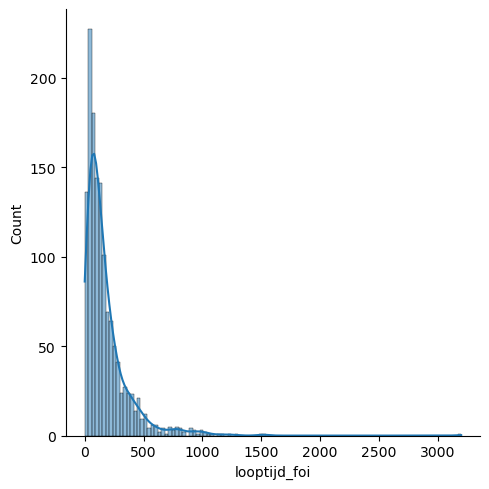

In [19]:
sns.displot(remove_outliers_foi(nacomb)['looptijd_foi'], kde=True)

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


count    681.000000
mean      58.164464
std       29.889935
min        0.000000
25%       35.000000
50%       56.000000
75%       83.000000
max      117.000000
Name: looptijd_foi, dtype: float64

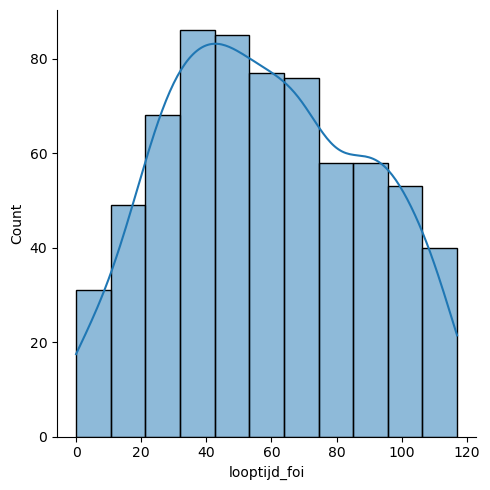

In [20]:
nacomb_allnolier = remove_outliers_foi(nacomb)
quant = 0.5
sns.displot(nacomb_allnolier[nacomb_allnolier['looptijd_foi'] < nacomb_allnolier['looptijd_foi'].quantile(quant)]['looptijd_foi'], kde=True)
nacomb_allnolier[nacomb_allnolier['looptijd_foi'] < nacomb_allnolier['looptijd_foi'].quantile(quant)]['looptijd_foi'].describe()

In [21]:
nacomb_noliers = remove_outliers_foi(nacomb).groupby('dc_publisher_name')['looptijd_foi'].describe().round(2)['50%']
diff = describe_zonder_outliers['50%'] - nacomb_noliers
display(diff)

describe_zonder_outliers['count'] - remove_outliers_foi(nacomb).groupby('dc_publisher_name')['looptijd_foi'].describe()['count']

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


dc_publisher_name
Ministerie Van Algemene Zaken                                4.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties    -5.5
Ministerie Van Buitenlandse Zaken                            0.0
Ministerie Van Defensie                                    -12.0
Ministerie Van Economische Zaken En Klimaat                 13.0
Ministerie Van Financiën                                   -23.5
Ministerie Van Infrastructuur En Waterstaat                 -5.0
Ministerie Van Justitie En Veiligheid                        0.0
Ministerie Van Landbouw, Natuur En Voedselkwaliteit          0.0
Ministerie Van Onderwijs, Cultuur En Wetenschap             -1.5
Ministerie Van Sociale Zaken En Werkgelegenheid             -6.0
Ministerie Van Volksgezondheid, Welzijn En Sport             7.5
Name: 50%, dtype: float64

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


dc_publisher_name
Ministerie Van Algemene Zaken                                10.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties     37.0
Ministerie Van Buitenlandse Zaken                            14.0
Ministerie Van Defensie                                      17.0
Ministerie Van Economische Zaken En Klimaat                  27.0
Ministerie Van Financiën                                     36.0
Ministerie Van Infrastructuur En Waterstaat                  40.0
Ministerie Van Justitie En Veiligheid                        18.0
Ministerie Van Landbouw, Natuur En Voedselkwaliteit         104.0
Ministerie Van Onderwijs, Cultuur En Wetenschap              14.0
Ministerie Van Sociale Zaken En Werkgelegenheid              13.0
Ministerie Van Volksgezondheid, Welzijn En Sport             15.0
Name: count, dtype: float64

In [22]:
print(f"Totaal aantal Woo-besluiten met outliers: {describe_met_outliers['count'].sum()}")
print(f"Gewogen gemiddelde doorlooptijd inclusief uitschieters: {combined['looptijd_foi'].mean()}")
print(f"Mediaan doorlooptijd inclusief uitschieters: {combined['looptijd_foi'].median()}")
describe_met_outliers

Totaal aantal Woo-besluiten met outliers: 1741.0
Gewogen gemiddelde doorlooptijd inclusief uitschieters: 182.82538770821367
Mediaan doorlooptijd inclusief uitschieters: 114.0


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,65.0,141.17,157.36,-229.0,45.00,105.0,179.00,901.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,123.0,150.89,190.22,-247.0,55.50,100.0,166.00,1493.0
Ministerie Van Buitenlandse Zaken,73.0,130.38,103.00,9.0,49.00,113.0,184.00,596.0
Ministerie Van Defensie,65.0,109.22,114.98,7.0,33.00,55.0,154.00,551.0
Ministerie Van Economische Zaken En Klimaat,138.0,155.57,138.06,7.0,58.25,118.0,189.25,662.0
Ministerie Van Financiën,239.0,239.03,337.19,-286.0,92.00,160.0,284.00,3270.0
Ministerie Van Infrastructuur En Waterstaat,210.0,204.44,255.72,-183.0,56.00,113.0,244.00,1222.0
Ministerie Van Justitie En Veiligheid,175.0,215.18,269.02,-5.0,79.00,136.0,237.00,2197.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",422.0,186.58,265.00,-232.0,52.00,102.0,218.00,3372.0


# Aantal Woo-besluiten zonder uitschieters

Dit zijn de aantallen Woo-besluiten als de uitschieters en negatieve doorlooptijden zijn weggehaald.  
21 Woo-besluiten hadden vraagtekens bij de verzoekdatum, deze zijn hier ook niet in meegenomen.  

`count` laat zien hoeveel besluiten er zijn  
`mean` laat zien wat de gemiddelde doorlooptijd is van dat ministerie  
`50%` laat zien wat de mediaan van de doorlooptijd is van dat ministerie

In [23]:
print(f"Totaal aantal Woo-besluiten zonder outliers: {describe_zonder_outliers['count'].sum()}")
print(f"Gewogen gemiddelde doorlooptijd zonder uitschieters: {remove_outliers_foi(combined)['looptijd_foi'].mean()}")
print(f"Mediaan doorlooptijd zonder uitschieters: {remove_outliers_foi(combined)['looptijd_foi'].median()}")
describe_zonder_outliers

Totaal aantal Woo-besluiten zonder outliers: 1716.0
Gewogen gemiddelde doorlooptijd zonder uitschieters: 172.4067599067599
Mediaan doorlooptijd zonder uitschieters: 114.0


C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,63.0,134.98,118.32,0.0,47.00,105.0,173.00,525.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,121.0,143.09,142.81,7.0,56.00,100.0,163.00,784.0
Ministerie Van Buitenlandse Zaken,72.0,123.92,87.54,9.0,48.00,109.5,175.00,465.0
Ministerie Van Defensie,64.0,102.31,101.41,7.0,33.00,55.0,151.00,457.0
Ministerie Van Economische Zaken En Klimaat,138.0,155.57,138.06,7.0,58.25,118.0,189.25,662.0
Ministerie Van Financiën,236.0,215.87,192.58,5.0,92.50,159.0,283.25,1535.0
Ministerie Van Infrastructuur En Waterstaat,204.0,200.19,235.34,3.0,57.50,118.0,240.00,1184.0
Ministerie Van Justitie En Veiligheid,173.0,205.00,223.59,2.0,79.00,136.0,236.00,1496.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",417.0,174.57,196.24,0.0,52.00,101.0,217.00,1141.0


In [24]:
describe_paginas_zonder_outliers = remove_outliers_foi(combined).groupby('dc_publisher_name')['foi_nrPages'].describe().round(2)
describe_paginas_met_outliers = combined.groupby('dc_publisher_name')['foi_nrPages'].describe().round(2)

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


# Aantal pagina's

Dit gaat over alle 1762 Woo-besluiten, inclusief de 21 Woo-besluiten met missende verzoekdatum, en inclusief de (looptijd) uitschieters.

In [25]:
print(f"Gewogen gemiddeld aantal pagina's over het geheel: {combined['foi_nrPages'].mean()}")
print(f"Mediaan aantal pagina's over het geheel: {combined['foi_nrPages'].median()}")
print(f"Totaal aantal pagina's over alle (1762) Woo-besluiten: {combined['foi_nrPages'].sum()}")
print('')
print(f"Aantal Woo-besluiten met 50 of minder pagina's:")
minder_dan_vijftig = combined[combined['foi_nrPages'] < 50]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(minder_dan_vijftig)
print('')
print(f"Aantal Woo-besluiten met 51 tot en met 250 pagina's:")
vijftig_tm_250 = combined[(combined['foi_nrPages'] >= 50) & (combined['foi_nrPages'] <= 250)]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(vijftig_tm_250)
print('')
print(f"Aantal Woo-besluiten met meer dan 250 pagina's:")
meer_dan_250 = combined[combined['foi_nrPages'] > 250]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(meer_dan_250)
print('')
print(f"Percentage 50 of minder:      {round(minder_dan_vijftig['count']/combined.shape[0]*100, 2)}%")
print(f"Percentage 51 tot en met 250: {round(vijftig_tm_250['count']/combined.shape[0]*100, 2)}%")
print(f"Percentage hoger dan 250:     {round(meer_dan_250['count']/combined.shape[0]*100, 2)}%")

display(describe_paginas_met_outliers)

Gewogen gemiddeld aantal pagina's over het geheel: 206.60839954597049
Mediaan aantal pagina's over het geheel: 33.0
Totaal aantal pagina's over alle (1762) Woo-besluiten: 364044.0

Aantal Woo-besluiten met 50 of minder pagina's:
count    989.00000
mean      13.77452
50%        9.00000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met 51 tot en met 250 pagina's:
count    484.00000
mean     118.77686
50%      105.00000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met meer dan 250 pagina's:
count     289.000000
mean     1013.608997
50%       493.000000
Name: foi_nrPages, dtype: float64

Percentage 50 of minder:      56.13%
Percentage 51 tot en met 250: 27.47%
Percentage hoger dan 250:     16.4%


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,65.0,12.83,23.97,1.0,2.00,4.0,8.00,128.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,125.0,156.82,545.94,0.0,8.00,27.0,110.00,5556.0
Ministerie Van Buitenlandse Zaken,77.0,155.64,214.73,2.0,11.00,50.0,225.00,1186.0
Ministerie Van Defensie,66.0,115.85,219.59,1.0,6.25,33.5,145.50,1194.0
Ministerie Van Economische Zaken En Klimaat,138.0,139.44,236.60,2.0,11.25,49.0,173.75,1733.0
Ministerie Van Financiën,240.0,148.37,723.45,1.0,5.00,18.0,95.25,8608.0
Ministerie Van Infrastructuur En Waterstaat,210.0,244.30,734.38,1.0,7.00,42.5,189.00,7750.0
Ministerie Van Justitie En Veiligheid,180.0,291.65,854.63,2.0,14.00,51.0,207.75,7959.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",424.0,160.37,427.30,0.0,7.00,22.0,98.00,5005.0


In [26]:
matglas = pd.read_pickle('data/ExcelToDF/sheetsMG.pkl.gz', compression='gzip')
traag = pd.read_pickle('data/ExcelToDF/sheetsOT.pkl.gz', compression='gzip')

matglas.rename(columns={'Ministerie':'dc_publisher_name', 
                        'Aantal dagen \nin behandeling':'looptijd_foi',
                        'Binnen de \ntermijn afgehandeld':'termijn_bool',
                        "Omvang document (aantal pagina's)\n":'foi_nrPages'}, inplace=True)

traag.rename(columns={'Ministerie':'dc_publisher_name', 
                      'Aantal dagen \nin behandeling':'looptijd_foi',
                      'Binnen de \ntermijn afgehandeld':'termijn_bool',
                      "Omvang document (aantal pagina's)\n":'foi_nrPages'}, inplace=True)

matglas['Rapport'] = 'Matglas'
traag['Rapport'] = 'Ondraaglijk Traag'
combined['Rapport'] = '2023'

In [27]:
# verschillende kolommen met paginanummers in de OT excels samenvoegen

traag["foi_nrPages"] = traag["foi_nrPages"].combine_first(traag['Omvang document']).combine_first(traag["Omvang document (aantal pagina's)"])

In [28]:
def annotate(data, **kws):
    n = len(data)
    p = data.groupby(['dc_publisher_name', 'Rapport'])[['Doorlooptijd']].count()
    ax = plt.gca()
    ax.text(.1, 0.9, f"N = {p.iloc[2,0]}", transform=ax.transAxes)
    ax.text(.45, 0.9, f"N = {p.iloc[1,0]}", transform=ax.transAxes)
    ax.text(.8, 0.9, f"N = {p.iloc[0,0]}", transform=ax.transAxes)

# 3x12 boxplots met de doorlooptijden

De data uit de excelbestanden is gebruikt voor de plots van Matglas en Ondraaglijk Traag  
Voor de data uit 2023 zijn de uitschieters weggehaald, dus is de N een beetje lager bij sommige ministeries.  
De 'normale' uitschieters worden niet weergegeven, maar tellen wel mee in de berekening.  

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\1675859488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.rename(columns={'looptijd_foi':'Doorlooptijd'}, inplace=True)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
S:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout

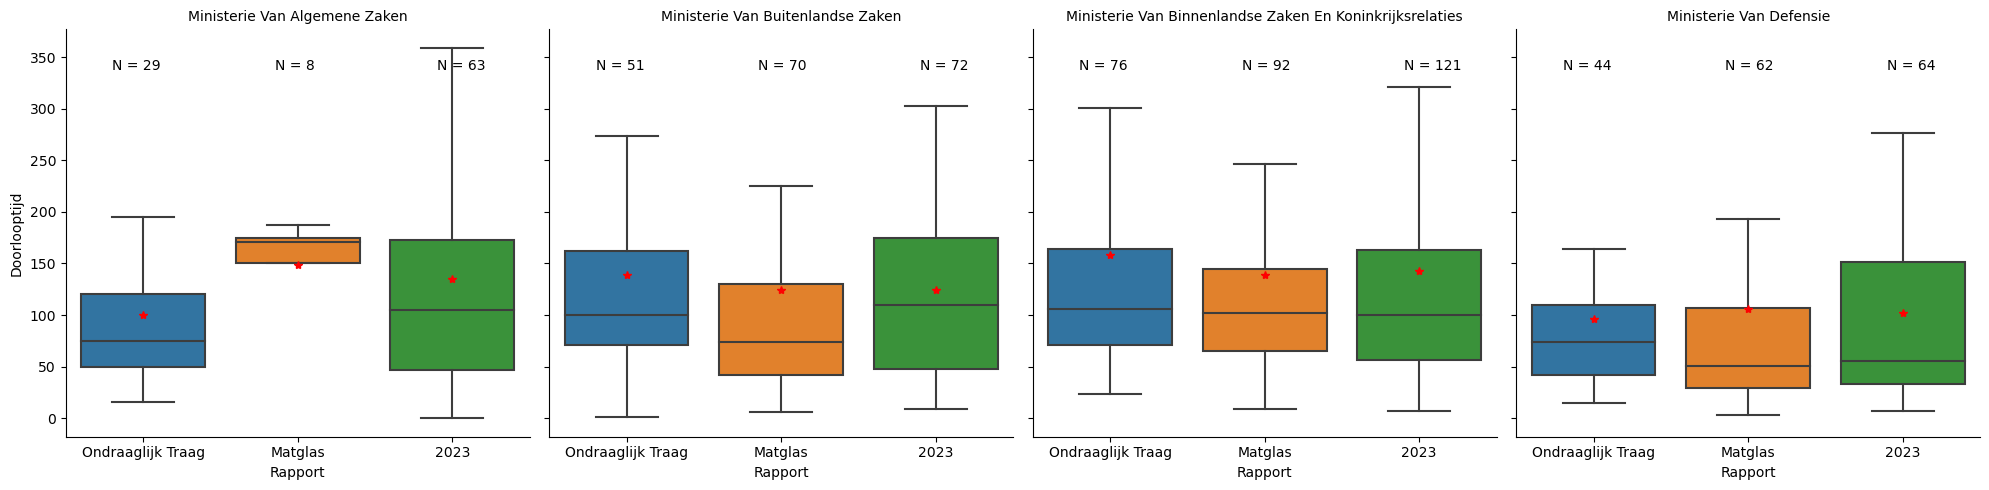

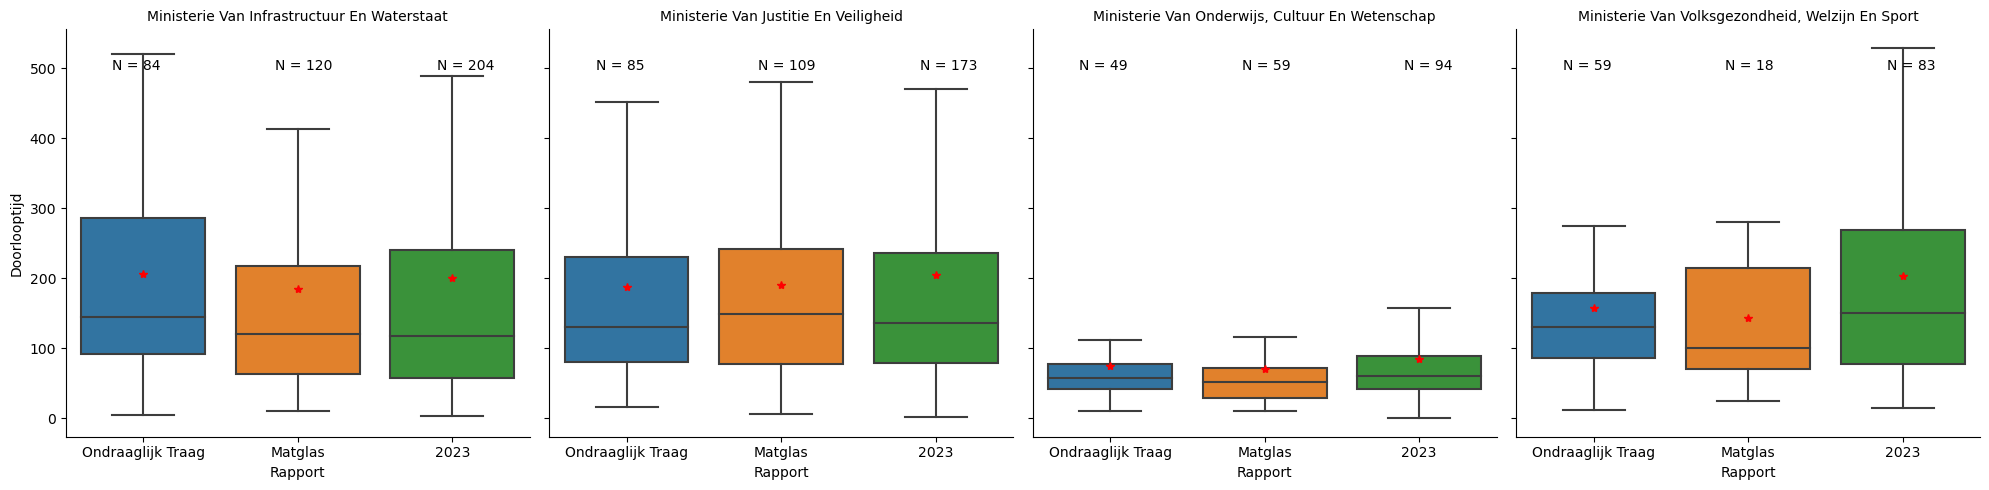

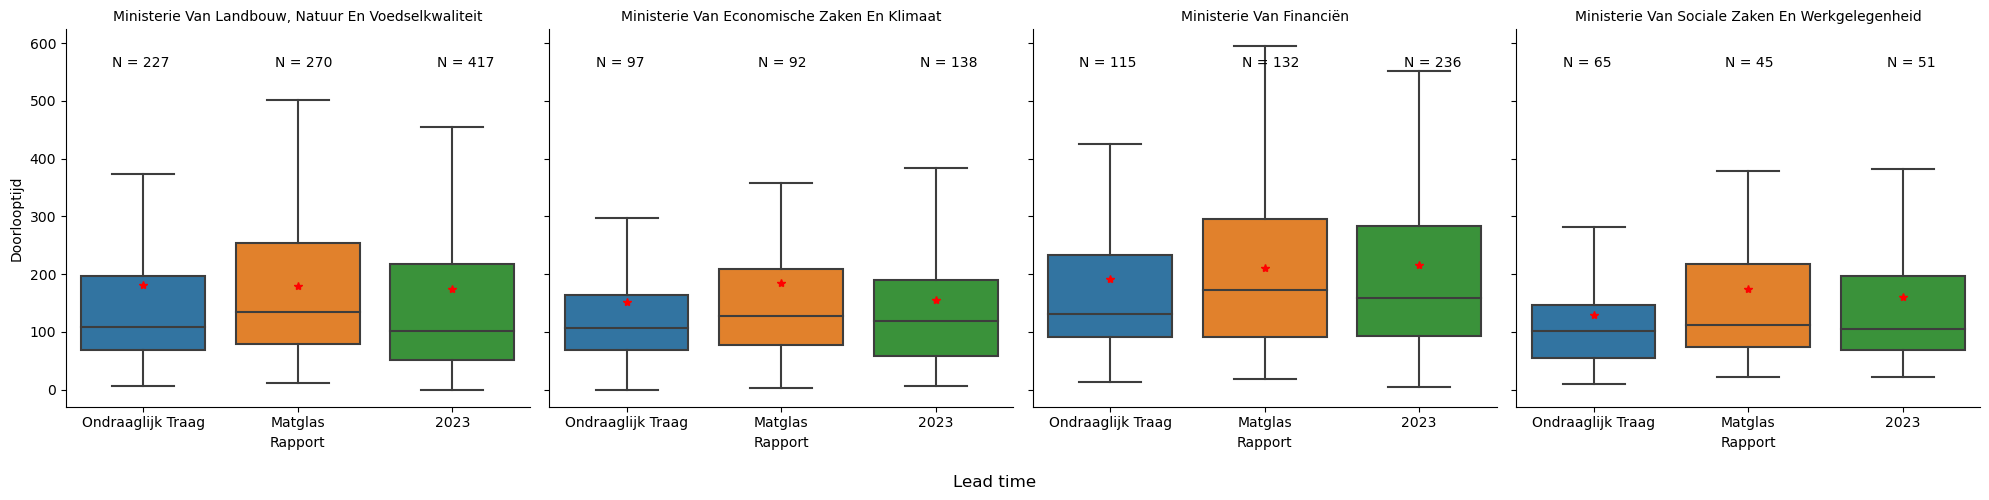

In [29]:
def compdia_plot(df1, df2, df3):
    df1.rename(columns={'looptijd_foi':'Doorlooptijd'}, inplace=True)
    df2.rename(columns={'looptijd_foi':'Doorlooptijd'}, inplace=True)
    df3.rename(columns={'looptijd_foi':'Doorlooptijd'}, inplace=True)
    
    
    plotframe = pd.concat([df1, df2, df3])

    bad = ['Ministerie Van Algemene Zaken',
           'Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties',
           'Ministerie Van Defensie', 
           'Ministerie Van Buitenlandse Zaken'
           ]

    good = ['Ministerie Van Financiën',
            'Ministerie Van Sociale Zaken En Werkgelegenheid',
            'Ministerie Van Economische Zaken En Klimaat', 
            'Ministerie Van Landbouw, Natuur En Voedselkwaliteit']

    same = ['Ministerie Van Onderwijs, Cultuur En Wetenschap',
            'Ministerie Van Infrastructuur En Waterstaat',
            'Ministerie Van Justitie En Veiligheid',
            'Ministerie Van Volksgezondheid, Welzijn En Sport', 
            ]

    bad_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == bad[0]) | 
                                   (plotframe['dc_publisher_name'] == bad[1]) | 
                                   (plotframe['dc_publisher_name'] == bad[2]) | 
                                   (plotframe['dc_publisher_name'] == bad[3])]

    same_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == same[0]) | 
                                   (plotframe['dc_publisher_name'] == same[1]) | 
                                   (plotframe['dc_publisher_name'] == same[2]) | 
                                   (plotframe['dc_publisher_name'] == same[3])]

    good_plotframe = plotframe.loc[(plotframe['dc_publisher_name'] == good[0]) | 
                                   (plotframe['dc_publisher_name'] == good[1]) | 
                                   (plotframe['dc_publisher_name'] == good[2]) | 
                                   (plotframe['dc_publisher_name'] == good[3])]

    bad = sns.catplot(data=bad_plotframe,
               x='Rapport',
               y='Doorlooptijd',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    bad.set_titles("{col_name}")
    bad.map_dataframe(annotate)
    bad.savefig('data/laatste_meting/plots/bad_plot.svg')

    same = sns.catplot(data=same_plotframe,
               x='Rapport',
               y='Doorlooptijd',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    same.set_titles("{col_name}")
    same.map_dataframe(annotate)
    same.savefig('data/laatste_meting/plots/same_plot.svg')

    good = sns.catplot(data=good_plotframe,
               x='Rapport',
               y='Doorlooptijd',
               col='dc_publisher_name',
               kind='box',
               showmeans=True,
               meanprops={"marker": "*",
                          "markerfacecolor": "red",
                          "markeredgecolor": "red"},
                showfliers=False
               )
    good.set_titles("{col_name}")
    good.fig.supxlabel('Lead time')
    good.map_dataframe(annotate)
    good.savefig('data/laatste_meting/plots/good_plot.svg')
    
compdia_plot(traag, matglas, remove_outliers_foi(combined))

# Aantal pagina's per ministerie

Aantal pagina's per ministerie, met het gemiddelde als blauw puntje.  
Er is niet gefiltered, 'uitschieters' worden niet weergegeven, maar tellen wel mee in de berekening.  
Onder deze grafiek staat een voorbeeld waar de uitschieters wel worden weergegeven, dat laat zien waarom die niet worden weergegeven.  

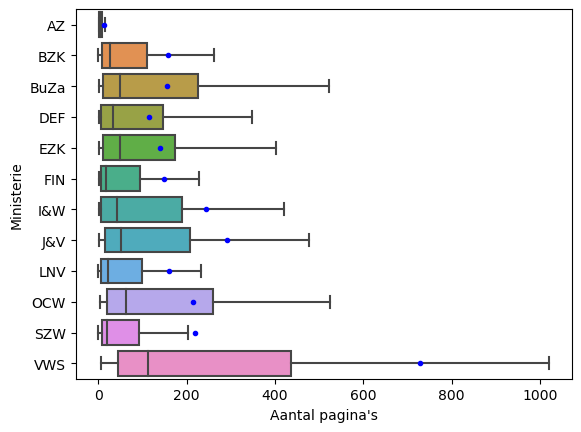

In [30]:
order = sorted(combined['dc_publisher_name_short'].unique())

fig, ax = plt.subplots()

minpag = sns.boxplot(data=combined, 
            x="foi_nrPages", 
            y="dc_publisher_name_short", 
            showfliers=False, 
            order=order,
            showmeans=True,
            meanprops={"marker": ".",
                          "markerfacecolor": "blue",
                          "markeredgecolor": "blue"}).set(
                             xlabel="Aantal pagina's", 
                             ylabel="Ministerie"
                            );

plt.savefig('data/laatste_meting/plots/minpagina.svg')

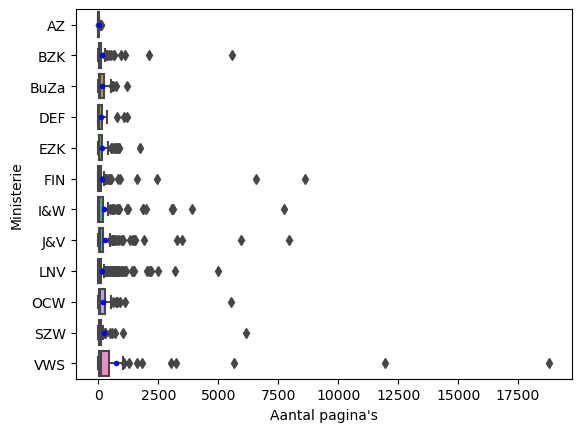

In [31]:
order = sorted(combined['dc_publisher_name_short'].unique())

sns.boxplot(data=combined, 
            x="foi_nrPages", 
            y="dc_publisher_name_short", 
            order=order,
            showmeans=True,
            meanprops={"marker": ".",
                          "markerfacecolor": "blue",
                          "markeredgecolor": "blue"}).set(
                             xlabel="Aantal pagina's", 
                             ylabel="Ministerie"
                            );

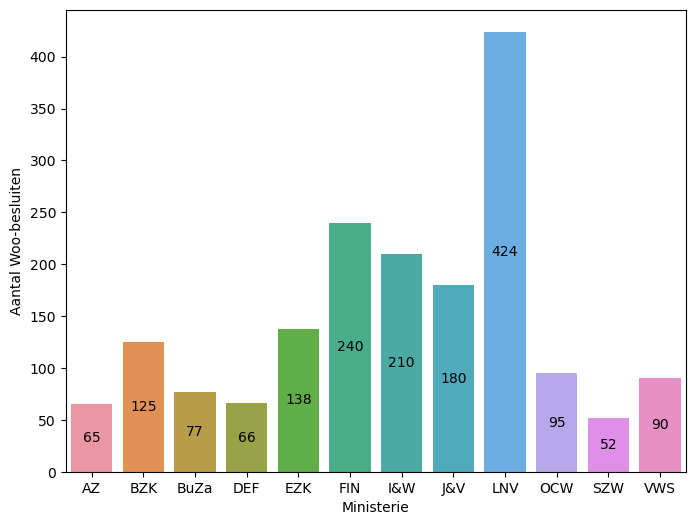

In [32]:
# sns.countplot(combined, x="dc_publisher_name_short").set(ylabel='Aantal Woo-besluiten', xlabel='Ministerie');

fig, ax = plt.subplots(figsize=(8, 6))

# add the plot
mincount = sns.countplot(combined, x="dc_publisher_name_short", ax=ax, order=order)

# add the annotation
ax.bar_label(ax.containers[-1], label_type='center')

ax.set(ylabel='Aantal Woo-besluiten')
ax.set(xlabel='Ministerie')

fig.savefig('data/laatste_meting/plots/mincount.svg')

plt.show()

# Termijn

De oranje balk gaat tot het totaal aantal verzoeken.  
De blauwe balk gaat over hoeveel verzoeken er binnen de termijn (42 dagen of minder) zijn behandeld.  
Uitschieters en negatieve doorlooptijden zijn weggehaald.  

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


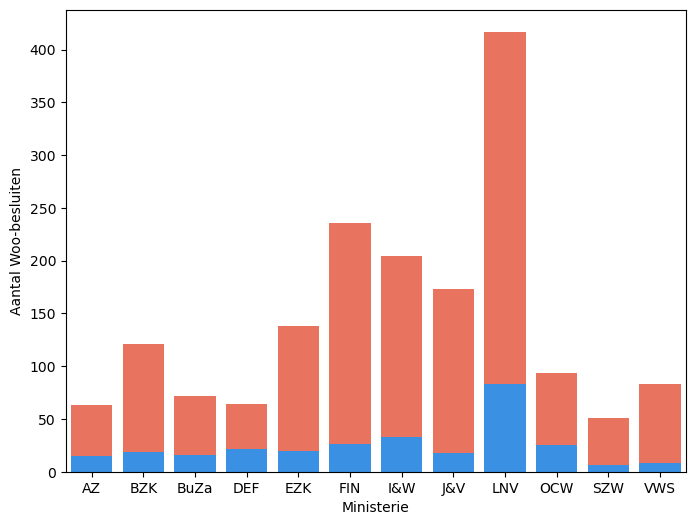

In [33]:
total = remove_outliers_foi(combined)
underterm = remove_outliers_foi(combined)[remove_outliers_foi(combined)['looptijd_foi'] <= 42]

fig, ax = plt.subplots(figsize=(8, 6))

sns.color_palette()

sns.countplot(data=total, x='dc_publisher_name_short', color='tomato', order=order)
sns.countplot(data=underterm, x='dc_publisher_name_short', color='dodgerblue', order=order)

ax.set(ylabel='Aantal Woo-besluiten');
ax.set(xlabel='Ministerie');

plt.savefig('data/laatste_meting/plots/termijn_stacked.svg')

In [34]:
overterm = remove_outliers_foi(combined)[remove_outliers_foi(combined)['looptijd_foi'] > 42]

total_count = remove_outliers_foi(combined).groupby('dc_publisher_name_short')['dc_publisher_name_short'].count()
overterm_count = overterm.groupby('dc_publisher_name_short')['dc_publisher_name_short'].count()

term_percentages = overterm_count * 100 / total_count

# sns.barplot(data=term_percentages, y='dc_publisher_name_short')
display(term_percentages)
print(f"Aantal Woo-besluiten die langer duurden van 42 dagen: {overterm.shape[0]}")
print(f"Aantal Woo-besluiten die 42 dagen of minder duurden:  {underterm.shape[0]}")
print('(Uitschieters en negatieve doorlooptijden zijn weggehaald)')

C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]
C:\Users\Joran\AppData\Local\Temp\ipykernel_10872\83269238.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(cutoff_filter) & (df['looptijd_foi'] >= 0)]


dc_publisher_name_short
AZ      76.190476
BZK     84.297521
BuZa    77.777778
DEF     65.625000
EZK     85.507246
FIN     88.983051
I&W     83.823529
J&V     89.595376
LNV     80.095923
OCW     73.404255
SZW     88.235294
VWS     90.361446
Name: dc_publisher_name_short, dtype: float64

Aantal Woo-besluiten die langer duurden van 42 dagen: 1425
Aantal Woo-besluiten die 42 dagen of minder duurden:  291
(Uitschieters en negatieve doorlooptijden zijn weggehaald)


In [38]:
from IPython.display import HTML

def html(df):
    display(HTML(df.to_html(render_links=True, escape=False)))

In [58]:
combined[(~combined['dc_source'].str.contains('open.minvws'))]['foi_nrPages'].sort_values(ascending=False).mean()

216.37037037037038

In [47]:
combined[(combined['dc_publisher_name'] == 'Ministerie Van Volksgezondheid, Welzijn En Sport')].shape

(90, 36)

In [59]:
html(combined[(combined['dc_publisher_name'] == 'Ministerie Van Volksgezondheid, Welzijn En Sport') & 
              (~combined['dc_source'].str.contains('open.minvws'))][['foi_nrPages', 'dc_source', 'dc_title']].sort_values(ascending=False, by='foi_nrPages').head(100))

,foi_nrPages,dc_source,dc_title
foi_dossierId,,,
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.194,1286.0,https://open.overheid.nl/Details/c2702a01-0dac-4c1b-afd8-73cdf7d398c1/1,2e deelbesluit op Woo-verzoek over jaarverantwoording Wtza
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.184,1021.0,https://open.overheid.nl/Details/9170608d-7c33-4678-b2ab-46ecfd4a0b66/2,Besluit op Woo-verzoek over accijnsverhoging tabak
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.7,974.0,https://open.overheid.nl/Details/ronl-67e7ceb5caeced65dca64c62cab9a79b8ef721e1/1,Eerste deelbesluit op Woo-verzoek over Transparantieregister Zorg
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.183,871.0,https://open.overheid.nl/Details/625ce9f8-09a8-4da8-9b2a-405528193862/2,Besluit op Wob-/Woo-verzoek over uitstoot stoffen Tata Steel IJmuiden
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.166,784.0,https://open.overheid.nl/Details/6dc7385f-62ec-4d9c-a643-298b71e7add1/2,Besluit op Woo-verzoek over onderzoek IGJ naar JeugdplusJeugd B.V.
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.182,751.0,https://open.overheid.nl/Details/12820cd4-cd36-4cf2-b9de-f1a3c990fdc9/1,"Beslissing op bezwaar Woo-besluit over zelfgekozen levenseinde, euthanasie, voltooid leven en suïcide"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.195,717.0,https://open.overheid.nl/Details/3113a066-94db-42b2-97b9-250171a71811/1,"Besluit op Woo-verzoek over Preventietafel, thematafel alcohol"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.19,668.0,https://open.overheid.nl/Details/ronl-bb5edc044d3036a0b189b84e492058529e1a88e1/1,2e Deelbesluit op Woo-verzoek over handhaving van overtredingen van de Alcoholwet door buitenlandse aanbieders
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.186,613.0,https://open.overheid.nl/Details/6a35582a-8bb8-4df2-8790-001b1784cf57/3,Deelbesluit 2 op Woo-verzoek over Veehouderij en Gezondheid Omwonenden (VGO)


In [67]:
combined[~combined['dc_source'].str.contains('open.minvws')].groupby('dc_publisher_name')['foi_nrPages'].describe().round(2)[['count', 'mean', '50%']]

,count,mean,50%
dc_publisher_name,,,
Ministerie Van Algemene Zaken,65.0,12.83,4.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,125.0,156.82,27.0
Ministerie Van Buitenlandse Zaken,77.0,155.64,50.0
Ministerie Van Defensie,66.0,115.85,33.5
Ministerie Van Economische Zaken En Klimaat,138.0,139.44,49.0
Ministerie Van Financiën,240.0,148.37,18.0
Ministerie Van Infrastructuur En Waterstaat,210.0,244.30,42.5
Ministerie Van Justitie En Veiligheid,180.0,291.65,51.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",424.0,160.37,22.0


In [64]:
html(combined[combined['dc_source'].str.contains('open.minvws')][['dc_title', 'foi_nrPages', 'dc_source', 'dc_publisher_name']])

,dc_title,foi_nrPages,dc_source,dc_publisher_name
foi_dossierId,,,,
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.199,Woo-deelbesluit aangaande Testen over de periode december 2020 | OpenVWS,3227.0,https://open.minvws.nl/dossier/3697817-1053825-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.200,Woo-deelbesluit aangaande Testen over de periode januari 2021 | OpenVWS,5677.0,https://open.minvws.nl/dossier/3695364-1053565-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.201,Woo-deelbesluit aangaande Overleg VWS over de periode mei 2021 | OpenVWS,1825.0,https://open.minvws.nl/dossier/3573889-1046310-PDO,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.204,Woo-deelbesluit aangaande Overleg VWS over de periode maart 2021 | OpenVWS,804.0,https://open.minvws.nl/dossier/3551818-1045128-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.205,Woo-deelbesluit aangaande Vaccinaties en Medicatie over de periode december 2020 | OpenVWS,11958.0,https://open.minvws.nl/dossier/3395155-1032354-PDO,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.206,Woo-deelbesluit aangaande Overleg VWS over de periode april 2021 | OpenVWS,1068.0,https://open.minvws.nl/dossier/3574524-1046390-PDO,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.207,Woo-deelbesluit aangaande Scenarios en maatregelen over de periode september 2020 | OpenVWS,18798.0,https://open.minvws.nl/dossier/3561075-1045762-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.208,Woo-deelbesluit aangaande Testen over de periode februari 2021 | OpenVWS,3042.0,https://open.minvws.nl/dossier/3663666-1052663-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"
https://doi.wooverheid.nl/?doi=nl.mnre1025.2i.2023.209,"Woo-deelbesluit aangaande Overleg VWS over de periode juni, juli en augustus 2021 | OpenVWS",1605.0,https://open.minvws.nl/dossier/3695163-1053545-pdo,"Ministerie Van Volksgezondheid, Welzijn En Sport"


In [72]:
no_corona = combined[~combined['dc_source'].str.contains('open.minvws')].copy()

describe_paginas_met_outliers_nc = no_corona.groupby('dc_publisher_name')['foi_nrPages'].describe().round(2)

print('Zonder Corona-besluiten\n')

print(f"Gewogen gemiddeld aantal pagina's over het geheel: {no_corona['foi_nrPages'].mean()}")
print(f"Mediaan aantal pagina's over het geheel: {no_corona['foi_nrPages'].median()}")
print(f"Totaal aantal pagina's over alle ({no_corona.shape[0]}) Woo-besluiten zonder corona: {no_corona['foi_nrPages'].sum()}")
print('')
print(f"Aantal Woo-besluiten met 50 of minder pagina's:")
minder_dan_vijftig_nc = no_corona[no_corona['foi_nrPages'] < 50]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(minder_dan_vijftig_nc)
print('')
print(f"Aantal Woo-besluiten met 51 tot en met 250 pagina's:")
vijftig_tm_250_nc = no_corona[(no_corona['foi_nrPages'] >= 50) & (no_corona['foi_nrPages'] <= 250)]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(vijftig_tm_250_nc)
print('')
print(f"Aantal Woo-besluiten met meer dan 250 pagina's:")
meer_dan_250_nc = no_corona[no_corona['foi_nrPages'] > 250]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(meer_dan_250_nc)
print('')
print(f"Percentage 50 of minder:      {round(minder_dan_vijftig_nc['count']/no_corona.shape[0]*100, 2)}%")
print(f"Percentage 51 tot en met 250: {round(vijftig_tm_250_nc['count']/no_corona.shape[0]*100, 2)}%")
print(f"Percentage hoger dan 250:     {round(meer_dan_250_nc['count']/no_corona.shape[0]*100, 2)}%")

display(describe_paginas_met_outliers_nc)

Zonder Corona-besluiten

Gewogen gemiddeld aantal pagina's over het geheel: 180.28522532800912
Mediaan aantal pagina's over het geheel: 32.0
Totaal aantal pagina's over alle (1753) Woo-besluiten zonder corona: 316040.0

Aantal Woo-besluiten met 50 of minder pagina's:
count    989.00000
mean      13.77452
50%        9.00000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met 51 tot en met 250 pagina's:
count    484.00000
mean     118.77686
50%      105.00000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met meer dan 250 pagina's:
count    280.000000
mean     874.746429
50%      484.000000
Name: foi_nrPages, dtype: float64

Percentage 50 of minder:      56.42%
Percentage 51 tot en met 250: 27.61%
Percentage hoger dan 250:     15.97%


,count,mean,std,min,25%,50%,75%,max
dc_publisher_name,,,,,,,,
Ministerie Van Algemene Zaken,65.0,12.83,23.97,1.0,2.00,4.0,8.00,128.0
Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties,125.0,156.82,545.94,0.0,8.00,27.0,110.00,5556.0
Ministerie Van Buitenlandse Zaken,77.0,155.64,214.73,2.0,11.00,50.0,225.00,1186.0
Ministerie Van Defensie,66.0,115.85,219.59,1.0,6.25,33.5,145.50,1194.0
Ministerie Van Economische Zaken En Klimaat,138.0,139.44,236.60,2.0,11.25,49.0,173.75,1733.0
Ministerie Van Financiën,240.0,148.37,723.45,1.0,5.00,18.0,95.25,8608.0
Ministerie Van Infrastructuur En Waterstaat,210.0,244.30,734.38,1.0,7.00,42.5,189.00,7750.0
Ministerie Van Justitie En Veiligheid,180.0,291.65,854.63,2.0,14.00,51.0,207.75,7959.0
"Ministerie Van Landbouw, Natuur En Voedselkwaliteit",424.0,160.37,427.30,0.0,7.00,22.0,98.00,5005.0


In [93]:
poepie = no_corona[(no_corona['dc_publisher_name'] == 'Ministerie Van Volksgezondheid, Welzijn En Sport')]

In [94]:
print(f"Aantal Woo-besluiten met 50 of minder pagina's:")
minder_dan_vijftig_nc_vws = poepie[poepie['foi_nrPages'] < 50]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(minder_dan_vijftig_nc_vws)
print('')
print(f"Aantal Woo-besluiten met 51 tot en met 250 pagina's:")
vijftig_tm_250_nc_vws = poepie[(poepie['foi_nrPages'] >= 50) & (poepie['foi_nrPages'] <= 250)]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(vijftig_tm_250_nc_vws)
print('')
print(f"Aantal Woo-besluiten met meer dan 250 pagina's:")
meer_dan_250_nc_vws = poepie[poepie['foi_nrPages'] > 250]['foi_nrPages'].describe()[['count', 'mean', '50%']]
print(meer_dan_250_nc_vws)
print('')
print(f"Percentage 50 of minder:      {round(minder_dan_vijftig_nc_vws['count']/poepie.shape[0]*100, 2)}%")
print(f"Percentage 51 tot en met 250: {round(vijftig_tm_250_nc_vws['count']/poepie.shape[0]*100, 2)}%")
print(f"Percentage hoger dan 250:     {round(meer_dan_250_nc_vws['count']/poepie.shape[0]*100, 2)}%")


Aantal Woo-besluiten met 50 of minder pagina's:
count    24.000000
mean     20.208333
50%      17.500000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met 51 tot en met 250 pagina's:
count     33.000000
mean     109.333333
50%       91.000000
Name: foi_nrPages, dtype: float64

Aantal Woo-besluiten met meer dan 250 pagina's:
count     24.000000
mean     559.708333
50%      479.000000
Name: foi_nrPages, dtype: float64

Percentage 50 of minder:      29.63%
Percentage 51 tot en met 250: 40.74%
Percentage hoger dan 250:     29.63%


In [99]:
def ppmin(ministerie, df):
    minder_dan_vijftig_nc_vws = df[df['foi_nrPages'] < 50]['foi_nrPages'].describe()[['count', 'mean', '50%']]
    vijftig_tm_250_nc_vws = df[(df['foi_nrPages'] >= 50) & (df['foi_nrPages'] <= 250)]['foi_nrPages'].describe()[['count', 'mean', '50%']]
    meer_dan_250_nc_vws = df[df['foi_nrPages'] > 250]['foi_nrPages'].describe()[['count', 'mean', '50%']]
    print(f"Ministerie: {ministerie} ")
    perc_less50 = round(minder_dan_vijftig_nc_vws['count']/df.shape[0]*100, 2)
    perc_50_250 = round(vijftig_tm_250_nc_vws['count']/df.shape[0]*100, 2)
    perc_more250 = round(meer_dan_250_nc_vws['count']/df.shape[0]*100, 2)
    print(f"Percentage 50 of minder:      {perc_less50}%")
    print(f"Percentage 51 tot en met 250: {perc_50_250}%")
    print(f"Percentage hoger dan 250:     {perc_more250}%")
    print(f"{perc_less50 + perc_50_250 + perc_more250}\n")
for df in no_corona.groupby('dc_publisher_name'):
    ppmin(df[0], df[1])

Ministerie: Ministerie Van Algemene Zaken 
Percentage 50 of minder:      90.77%
Percentage 51 tot en met 250: 9.23%
Percentage hoger dan 250:     0.0%
100.0

Ministerie: Ministerie Van Binnenlandse Zaken En Koninkrijksrelaties 
Percentage 50 of minder:      56.0%
Percentage 51 tot en met 250: 30.4%
Percentage hoger dan 250:     13.6%
100.0

Ministerie: Ministerie Van Buitenlandse Zaken 
Percentage 50 of minder:      49.35%
Percentage 51 tot en met 250: 27.27%
Percentage hoger dan 250:     23.38%
100.0

Ministerie: Ministerie Van Defensie 
Percentage 50 of minder:      57.58%
Percentage 51 tot en met 250: 30.3%
Percentage hoger dan 250:     12.12%
100.0

Ministerie: Ministerie Van Economische Zaken En Klimaat 
Percentage 50 of minder:      50.0%
Percentage 51 tot en met 250: 34.78%
Percentage hoger dan 250:     15.22%
100.0

Ministerie: Ministerie Van Financiën 
Percentage 50 of minder:      62.08%
Percentage 51 tot en met 250: 29.17%
Percentage hoger dan 250:     8.75%
100.0

Ministeri